# Intial conditions for two-body Kepler problem

In this notebook, we will parameterize the motion (positions and velocities) of the two bodies in an elliptical orbit in terms of an angle $\phi$.

We will consider the center-of-mass coordinate $\vec{R} = m_1 \vec{r}_1 + m_2 \vec{r}_2$ and the displacement vector $\vec{r} = \vec{r}_1 - \vec{r}_2$.
For simplicity, we can consider the center-of-mass system, in which $\vec{R}= \vec{0}$, so the center of mass is located at the origin.
The displacement vector motion is essentially just a standard 1-body Kepler problem where the ``body'' moves as if it has a reduced mass $\mu = m_1m_2/(m_1+m_2)$. 
See for example https://en.wikipedia.org/wiki/Two-body_problem and the image below:

![https://upload.wikimedia.org/wikipedia/commons/1/1f/Two-body_Jacobi_coordinates.JPG](https://upload.wikimedia.org/wikipedia/commons/1/1f/Two-body_Jacobi_coordinates.JPG)

From lecture, we saw the displacement vector's position and velocity can be parameterized by for an eccentric orbit with eccentricity $\epsilon$

$r(\phi) = \frac{R_\mathrm{min}(1+\epsilon)}{1-\epsilon\cos\phi}$

$v_r = -\epsilon\sqrt{\frac{G(m_1+m_2)}{R_{\mathrm{min}}(1+\epsilon)}}\sin\phi$

$v_\phi = \sqrt{\frac{G(m_1+m_2)}{R_{\mathrm{min}}(1+\epsilon)}}(1-\epsilon\cos\phi)$

We will also make use of the conversion between polar coordinates and cartesian coordinates:

$\hat{r} = \cos\phi \hat{x} + \sin\phi \hat{y}$

$\hat{\phi} = -\sin\phi \hat{x} + \cos\phi \hat{y}$

Finally, we will convert everything back to original vectors instead of the displacement vectors using

$\vec{r}_1 = \vec{R} + \frac{m_2}{m_1+m_2}\vec{r}$

$\vec{r}_2 = \vec{R} - \frac{m_1}{m_1+m_2}\vec{r}$

and similarly for the velocities.

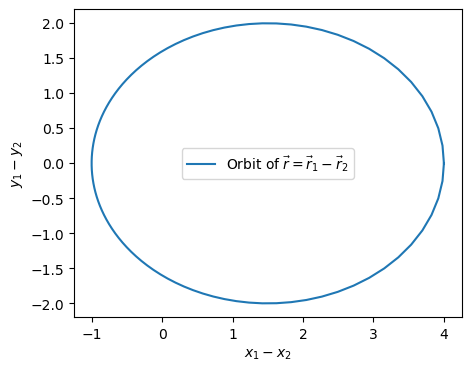

In [20]:
import numpy as np

m1 = 1
m2 = 1
rmin = 1
G = 1
e = 0.6


def r(phi):
    return rmin * (1 + e) / (1 - e * np.cos(phi))


def vr(phi):
    return -e * np.sqrt(G * (m1 + m2) / (rmin * (1 + e))) * np.sin(phi)


def vphi(phi):
    return np.sqrt(G * (m1 + m2) / (rmin * (1 + e))) * (1 - e * np.cos(phi))


def vx(phi):
    return vr(phi) * np.cos(phi) - vphi(phi) * np.sin(phi)


def vy(phi):
    return vr(phi) * np.sin(phi) + vphi(phi) * np.cos(phi)


def x(phi):
    return r(phi) * np.cos(phi)


def y(phi):
    return r(phi) * np.sin(phi)


import matplotlib.pyplot as plt

phi = np.linspace(0, 2 * np.pi, 100)

plt.figure(figsize=(5, 4))
plt.plot(x(phi), y(phi), label=r"Orbit of $\vec{r} = \vec{r}_1 - \vec{r}_2$")
plt.xlabel("$x_1 - x_2$")
plt.ylabel("$y_1 - y_2$")
plt.legend()
plt.show()

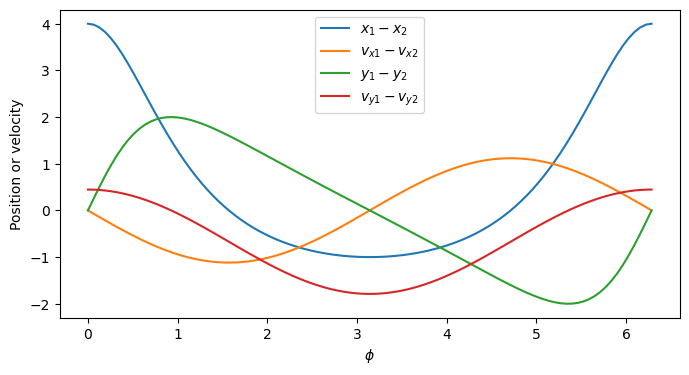

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(phi, x(phi), label="$x_1 - x_2$")
plt.plot(phi, vx(phi), label="$v_{x1} - v_{x2}$")
plt.plot(phi, y(phi), label="$y_1 - y_2$")
plt.plot(phi, vy(phi), label="$v_{y1} - v_{y2}$")
plt.xlabel("$\phi$")
plt.ylabel("Position or velocity")
plt.legend()
plt.show()

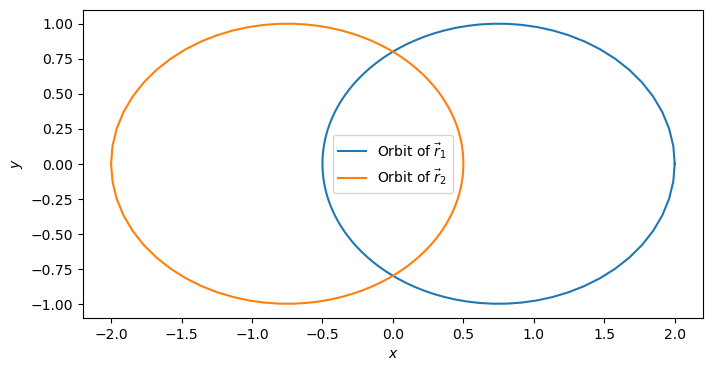

In [21]:
def x1(phi):
    return m2 / (m1 + m2) * x(phi)


def y1(phi):
    return m2 / (m1 + m2) * y(phi)


def x2(phi):
    return -m1 / (m1 + m2) * x(phi)


def y2(phi):
    return -m1 / (m1 + m2) * y(phi)


phi = np.linspace(0, 2 * np.pi, 100)

plt.figure(figsize=(8, 4))
plt.plot(x1(phi), y1(phi), label=r"Orbit of $\vec{r}_1$")
plt.plot(x2(phi), y2(phi), label=r"Orbit of $\vec{r}_2$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

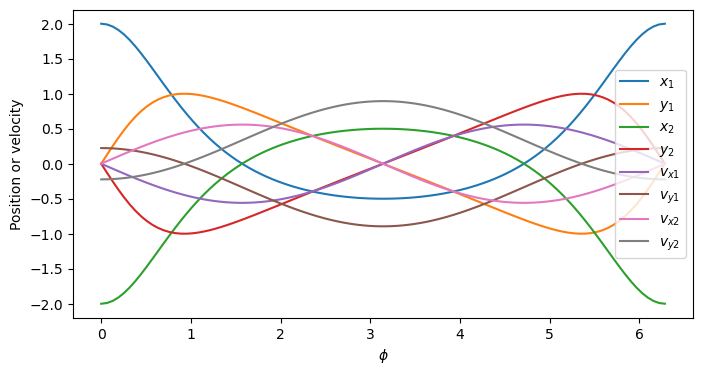

In [17]:
def vx1(phi):
    return m2 / (m1 + m2) * vx(phi)


def vy1(phi):
    return m2 / (m1 + m2) * vy(phi)


def vx2(phi):
    return -m1 / (m1 + m2) * vx(phi)


def vy2(phi):
    return -m1 / (m1 + m2) * vy(phi)


plt.figure(figsize=(8, 4))
plt.plot(phi, x1(phi), label="$x_1$")
plt.plot(phi, y1(phi), label="$y_1$")
plt.plot(phi, x2(phi), label="$x_2$")
plt.plot(phi, y2(phi), label="$y_2$")
plt.plot(phi, vx1(phi), label="$v_{x1}$")
plt.plot(phi, vy1(phi), label="$v_{y1}$")
plt.plot(phi, vx2(phi), label="$v_{x2}$")
plt.plot(phi, vy2(phi), label="$v_{y2}$")
plt.ylabel("Position or velocity")
plt.xlabel("$\phi$")
plt.legend()
plt.show()

## Validation with leapfrog integration

Now we can validate these initial conditions by evolving them forward in time with leapfrog integration

In [22]:
def getAcc(pos, mass, G, softening):
    """
    Calculate the acceleration on each particle due to Newton's Law
        pos  is an N x 3 matrix of positions
        mass is an N x 1 vector of masses
        G is Newton's Gravitational constant
        softening is the softening length
        a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = dx**2 + dy**2 + dz**2 + softening**2
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** (-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
    a = np.hstack((ax, ay, az))

    return a

<Figure size 320x400 with 0 Axes>

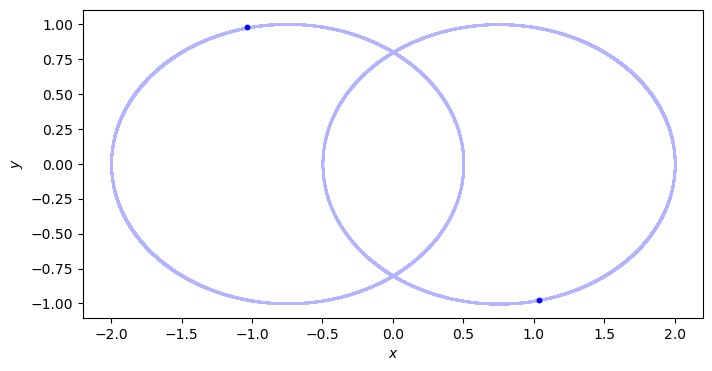

In [24]:
# Simulation parameters
N = 2  # Number of particles
t = 0  # current time of the simulation
tEnd = 100.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.01  # softening length

# Generate Initial Conditions
np.random.seed(17)  # set the random number generator seed

mass = np.array([[m1], [m2]])
pos = np.array([[x1(0), y1(0), 0], [x2(0), y2(0), 0]])
vel = np.array([[vx1(0), vy1(0), 0], [vx2(0), vy2(0), 0]])

# Convert to Center-of-Mass frame
vel -= np.mean(mass * vel, 0) / np.mean(mass)

# calculate initial gravitational accelerations
acc = getAcc(pos, mass, G, softening)

# number of timesteps
Nt = int(np.ceil(tEnd / dt))

# save energies, particle orbits for plotting trails
pos_save = np.zeros((N, 3, Nt + 1))
pos_save[:, :, 0] = pos
t_all = np.arange(Nt + 1) * dt

# Simulation Main Loop
for i in range(Nt):
    # (1/2) kick
    vel += acc * dt / 2.0

    # drift
    pos += vel * dt

    # update accelerations
    acc = getAcc(pos, mass, G, softening)

    # (1/2) kick
    vel += acc * dt / 2.0

    # update time
    t += dt

    # save energies, positions for plotting trail
    pos_save[:, :, i + 1] = pos

xx = pos_save[:, 0, :]
yy = pos_save[:, 1, :]
plt.figure(figsize=(8, 4))
plt.scatter(xx, yy, s=1, color=[0.7, 0.7, 1])
plt.scatter(pos[:, 0], pos[:, 1], s=10, color="blue")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()